## Pipeline

In [1]:
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import smplx
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data loading

Input: torch.Size([1, 3, 427, 640]), Float Input: torch.Size([1, 3, 427, 640])


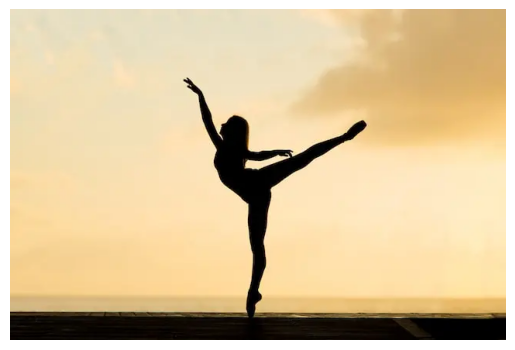

Image shape: H=427, W=640


In [2]:

def load_image(image_path):
    img = torchvision.io.read_image(image_path).to(device).unsqueeze(0)
    img_float = img.float() / 255.0
    print(f"Input: {img.shape}, Float Input: {img_float.shape}")
    # Show img
    plt.imshow(img[0].permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
    
    return img, img_float

data_path1 = "./data/dance.jpg"
img, img_float = load_image(data_path1)
H, W = img.shape[2], img.shape[3]
print(f"Image shape: H={H}, W={W}")

Input: torch.Size([1, 3, 866, 842]), Float Input: torch.Size([1, 3, 866, 842])


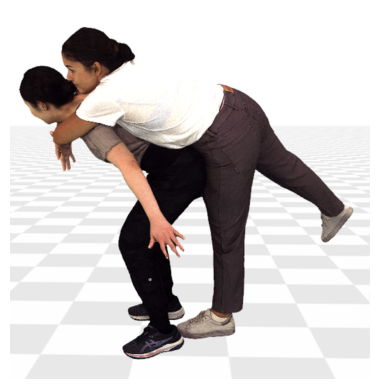

In [3]:
multi_person_path = "./data/occlusion.png"
img_multi, img_float_multi = load_image(multi_person_path)

### Model Loading

In [3]:
# Load NLF model
nlf_model_path = "models/nlf_checkpoint/nlf_l_multi.torchscript"
if not os.path.exists(nlf_model_path):
    print("Downloading NLF TorchScript model for fallback...")
    !wget -q -O {nlf_model_path} https://bit.ly/nlf_l_pt

nlf_model_jit = torch.jit.load(nlf_model_path, map_location=device).eval()
nlf_model = nlf_model_jit
smplx_model = smplx.SMPLX(model_path='models/smplx', gender='NEUTRAL', use_pca=False).to(device).eval()

print("NLF and SMPL-X models loaded.")

NLF and SMPL-X models loaded.


### Feature extraction

In [10]:
# Investigate NLF model structure
for name, module in nlf_model.named_children():
    print(f"Module: {name} | Type: {type(module)}")

print("\n")

for name, module in nlf_model.crop_model.named_children():
    print(f"Crop Model Module: {name} | Type: {type(module)}")
    
    
print('Crop model is the real backbone of NLF model.')

param = next(nlf_model.parameters())
model_param_dtype = param.dtype
print(f"NLF model has {len(param)} parameters, with type {model_param_dtype}.")

Module: crop_model | Type: <class 'torch.jit._script.RecursiveScriptModule'>
Module: detector | Type: <class 'torch.jit._script.RecursiveScriptModule'>
Module: fitter_smpl | Type: <class 'torch.jit._script.RecursiveScriptModule'>
Module: fitter_smplx | Type: <class 'torch.jit._script.RecursiveScriptModule'>


Crop Model Module: backbone | Type: <class 'torch.jit._script.RecursiveScriptModule'>
Crop Model Module: heatmap_head | Type: <class 'torch.jit._script.RecursiveScriptModule'>
Crop model is the real backbone of NLF model.
NLF model has 360 parameters, with type torch.float32.


In [5]:
nlf_feature = nlf_model.crop_model.backbone(img_float.half())
print("NLF feature shape:", nlf_feature.shape)
nlf_feature = nlf_model.crop_model.heatmap_head.layer(nlf_feature)
print("NLF feature after heatmap head shape:", nlf_feature.shape)

NLF feature shape: torch.Size([1, 1280, 14, 20])
NLF feature after heatmap head shape: torch.Size([1, 512, 14, 20])


In [ ]:
canonical_points = nlf_model.crop_model.canonical_locs()
weights = nlf_model.get_weights_for_canonical_points(canonical_points)

flip_flags = torch.zeros(nlf_feature.shape[0], dtype=torch.int32, device=device)


coords2d, coords3d, uncertainties = nlf_model.crop_model.heatmap_head.decode_features_multi_same_weights(
        nlf_feature, weights, flip_flags
    )

In [ ]:
print(f"Coords2D Shape: {coords2d.shape}")
print(f"Coords3D Shape: {coords3d.shape}")
print(f"Uncertainties Shape: {uncertainties.shape}")

In [ ]:
coords2d

### SMPLX param estimation

In [11]:
# Run batched detection
def nlf_predict(frame_batch):
    # frame_batch: [B,3,H,W] or a single image with batch dim
    image_dtype = frame_batch.dtype
    print(f"Input frame batch shape: {frame_batch.shape}, dtype: {image_dtype}")
    
    with torch.inference_mode():
        preds = nlf_model.detect_smpl_batched(frame_batch, model_name='smplx')
    return preds
    
def reconstruct_smplx_from_nlf_preds(preds, verbose=False):
    # preds typically contains keys: 'pose', 'betas', 'trans', plus nonparametric outputs
    pose = preds['pose'][0]
    betas = preds['betas'][0]
    transl = preds['trans'][0]
    
    if verbose:
        print('Prediction keys:', list(preds.keys()))
        for key in preds.keys():
           print(f"{key} -> {preds[key][0].shape}")

    
    # Call SMPL-X with batched tensors for multi-person support
    num_people = pose.shape[0]
    print(f"Number of detected people: {num_people}")
    res = []
    
    for i in range(num_people):
        result = smplx_model( 
            global_orient=pose[i, :3].unsqueeze(0),
            body_pose=pose[i, 3:22*3].unsqueeze(0),
            betas=betas[i, :].unsqueeze(0),
            transl=transl[i, :].unsqueeze(0),
            left_hand_pose=pose[i, 25*3:40*3].unsqueeze(0),
            right_hand_pose=pose[i, 40*3:55*3].unsqueeze(0),
            jaw_pose=pose[i, 22*3:23*3].unsqueeze(0),
            leye_pose=pose[i, 23*3:24*3].unsqueeze(0),
            reye_pose=pose[i, 24*3:25*3].unsqueeze(0)
        )
        res.append(result)
    
    if verbose and res is not None:
        try:
            print('Reconstructed vertices shape:', res[0].vertices.shape)
            print('Reconstructed joints shape:', res[0].joints.shape)
        except Exception as e:
            print('Warning while inspecting reconstruction output:', e)
    
    return res


**Note: NLF model only takes in uint8 images instead of the float type features**

In [15]:
# Run prediction on our loaded image (ensure it has batch dim).
# If `img` is a single image tensor of shape [1,3,H,W], this will work; if it's [3,H,W], add a batch dim.
if img.dim() == 3:
    frame_batch = img.unsqueeze(0)
else:
    frame_batch = img
    
print("frame_batch:", frame_batch.shape)
preds = nlf_predict(frame_batch)
smplx_output = reconstruct_smplx_from_nlf_preds(preds, verbose=True)

frame_batch: torch.Size([1, 3, 427, 640])
Input frame batch shape: torch.Size([1, 3, 427, 640]), dtype: torch.uint8
Prediction keys: ['boxes', 'pose', 'betas', 'trans', 'vertices3d', 'joints3d', 'vertices2d', 'joints2d', 'vertices3d_nonparam', 'joints3d_nonparam', 'vertices2d_nonparam', 'joints2d_nonparam', 'vertex_uncertainties', 'joint_uncertainties']
boxes -> torch.Size([1, 5])
pose -> torch.Size([1, 165])
betas -> torch.Size([1, 10])
trans -> torch.Size([1, 3])
vertices3d -> torch.Size([1, 10475, 3])
joints3d -> torch.Size([1, 55, 3])
vertices2d -> torch.Size([1, 10475, 2])
joints2d -> torch.Size([1, 55, 2])
vertices3d_nonparam -> torch.Size([1, 1024, 3])
joints3d_nonparam -> torch.Size([1, 55, 3])
vertices2d_nonparam -> torch.Size([1, 1024, 2])
joints2d_nonparam -> torch.Size([1, 55, 2])
vertex_uncertainties -> torch.Size([1, 1024])
joint_uncertainties -> torch.Size([1, 55])
Number of detected people: 1
Reconstructed vertices shape: torch.Size([1, 10475, 3])
Reconstructed joints s

In [ ]:
multi_preds = nlf_predict(img_multi)

In [ ]:
multi_smplx_output = reconstruct_smplx_from_nlf_preds(multi_preds, verbose=True)

Prediction keys: ['boxes', 'pose', 'betas', 'trans', 'vertices3d', 'joints3d', 'vertices2d', 'joints2d', 'vertices3d_nonparam', 'joints3d_nonparam', 'vertices2d_nonparam', 'joints2d_nonparam', 'vertex_uncertainties', 'joint_uncertainties']
boxes -> torch.Size([1, 5])
pose -> torch.Size([1, 165])
betas -> torch.Size([1, 10])
trans -> torch.Size([1, 3])
vertices3d -> torch.Size([1, 10475, 3])
joints3d -> torch.Size([1, 55, 3])
vertices2d -> torch.Size([1, 10475, 2])
joints2d -> torch.Size([1, 55, 2])
vertices3d_nonparam -> torch.Size([1, 1024, 3])
joints3d_nonparam -> torch.Size([1, 55, 3])
vertices2d_nonparam -> torch.Size([1, 1024, 2])
joints2d_nonparam -> torch.Size([1, 55, 2])
vertex_uncertainties -> torch.Size([1, 1024])
joint_uncertainties -> torch.Size([1, 55])
Number of detected people: 1
Reconstructed vertices shape: torch.Size([1, 10475, 3])
Reconstructed joints shape: torch.Size([1, 127, 3])


In [ ]:
from src.avatar_utils.camera import intrinsic_matrix_from_field_of_view

def plot_smplx(pred, image, special_points = None):
    K = intrinsic_matrix_from_field_of_view(55, image.shape[1:3])  # [1,3,3]

    def project_vertices(coords3d, K):
        # coords3d: [B,N,3] or [N,3]; K: [B,3,3] or [3,3]
        if coords3d.ndim == 2:  # add batch
            coords3d = coords3d.unsqueeze(0)
        if K.ndim == 2:
            K = K.unsqueeze(0)
        z = coords3d[..., 2:].clamp_min(1e-3)              # avoid division warning/NaN
        projected = coords3d / z
        return torch.einsum('bnk,bjk->bnj', projected, K[..., :2, :])

    verts3d = pred['vertices3d'][0].detach().cpu()         # [N,3] or [1,N,3]
    verts2d = project_vertices(verts3d, K).squeeze(0).numpy()
    print("Total vertices: ", verts2d.shape)


    fig, ax = plt.subplots()
    ax.imshow(image.cpu().numpy().transpose(1, 2, 0))
    ax.scatter(verts2d[:, 0], verts2d[:, 1], s=1, c='r', alpha=0.5)
    # If special points are provided, highlight them
    if special_points is not None:
        ax.scatter(verts2d[special_points, 0], verts2d[special_points, 1], s=10, c='b', alpha=0.8)
    ax.set_axis_off()
    plt.show()
    return


def plot_multi_smplx(pred, image, num_person = 0, special_points = None):
    K = intrinsic_matrix_from_field_of_view(55, image.shape[1:3])  # [1,3,3]

    def project_vertices(coords3d, K):
        # coords3d: [B,N,3] or [N,3]; K: [B,3,3] or [3,3]
        if coords3d.ndim == 2:  # add batch
            coords3d = coords3d.unsqueeze(0)
        if K.ndim == 2:
            K = K.unsqueeze(0)
        z = coords3d[..., 2:].clamp_min(1e-3)              # avoid division warning/NaN
        projected = coords3d / z
        return torch.einsum('bnk,bjk->bnj', projected, K[..., :2, :])

    verts3d = pred['vertices3d'][0].detach().cpu()         # [N,3] or [1,N,3]
    print("verts3d shape:", verts3d.shape)
    verts2d = project_vertices(verts3d, K).squeeze(0).numpy()
    print("Total vertices: ", verts2d.shape)


    fig, ax = plt.subplots()
    ax.imshow(image.cpu().numpy().transpose(1, 2, 0))
    ax.scatter(verts2d[num_person][:, 0], verts2d[num_person][:, 1], s=1, c='r', alpha=0.5)
    # If special points are provided, highlight them
    if special_points is not None:
        ax.scatter(verts2d[num_person][special_points, 0], verts2d[num_person][special_points, 1], s=10, c='b', alpha=0.8)
    ax.set_axis_off()
    plt.show()
    return


In [ ]:
plot_smplx(preds, img[0], special_points=[42, 8030])

verts3d shape: torch.Size([1, 10475, 3])
Total vertices:  (10475, 2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

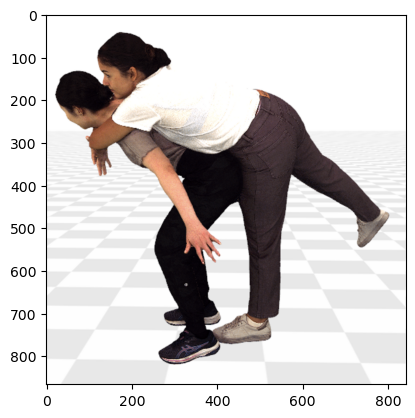

In [ ]:
plot_multi_smplx(multi_preds, img_multi[0], 0, special_points=[42, 8030])
plot_multi_smplx(multi_preds, img_multi[0], 1, special_points=[42, 8030])

### Avatar relocation

In [ ]:
# Given the smplx output, we can now generate a new mesh
from src.avatar_utils.camera import load_cano_mesh
cano_mesh_path = "models/smplx/smplx_uv.obj"
cano_mesh = load_cano_mesh(cano_mesh_path)

# Generate a new mesh based on smplx output
new_mesh = cano_mesh.copy()
new_mesh.vertices = smplx_output[0].vertices[0].detach().cpu().numpy()
# cano_mesh.vertices = smplx_output.vertices[0].detach().cpu().numpy()

# Save the modified mesh to a new file for test
output_mesh_path = "tmp/output_smplx_mesh.ply"
new_mesh.export(output_mesh_path)

In [ ]:
from src.encoder.avatar_template import AvatarTemplate
avatar_template_inference = AvatarTemplate()
# avatar_template = avatar_template_inference.load_avatar_template(mode="test")
# animated_avatar = avatar_template_inference.load_animated_avatar(mesh_path=output_mesh_path)

### Mask generation

In [ ]:
pts = preds["vertices2d_nonparam"][0][:, 0]   # (B, 1024, 2)
grid_x = pts[..., 0] / (img.shape[3] - 1) * 2 - 1  # Normalize to [-1, 1]
grid_y = pts[..., 1] / (img.shape[2] - 1) * 2 - 1  # Normalize to [-1, 1]
grid = torch.stack((grid_x, grid_y), dim=-1)  # (B, 1024, 2)
grid = grid.half()
sampled_feats = torch.nn.functional.grid_sample(
    nlf_feature,
    grid.view(img.shape[0], -1, 1, 2),
    align_corners=True,
    mode='bilinear',
    padding_mode='border'
).squeeze(-1).permute(0, 2, 1)  # (B, 1024, C)

print(sampled_feats)

#### Calculate latent code similarity

In [ ]:
H, W = img.shape[2], img.shape[3]
shape_tensor = torch.tensor([H, W], dtype=torch.float32).to(device)

def get_vertice_feature(vertex_id):
    coordinates = preds['vertices2d'][0][0][vertex_id] / shape_tensor  # [x, y]
    print(f"Vertex {vertex_id} coordinates: {coordinates}")
    # Bilinear sampling
    coordinates = coordinates * 2 - 1  # Normalize to [-1, 1]
    coordinates = coordinates.flip(0)  # (y, x) for grid_sample
    grid = coordinates.view(1, 1, 1, 2)  # [1,1,1,2]
    sampled_feature = torch.nn.functional.grid_sample(
        deep_features, 
        grid, 
        mode='bilinear', 
        align_corners=True
    )  # [1, C, 1, 1]
    return sampled_feature.squeeze(-1).squeeze(-1).squeeze(0)


def get_face_features(face_id):
    # Check if deep_features have batch size
    v1, v2, v3 = cano_mesh.faces[face_id]
    feat_v1 = get_vertice_feature(v1)
    feat_v2 = get_vertice_feature(v2)
    feat_v3 = get_vertice_feature(v3)
    
    B4 = [
        (1 / 3, 1 / 3, 1 / 3),
        (1 / 2, 1 / 2, 0),
        (1 / 2, 0, 1 / 2),
        (0, 1 / 2, 1 / 2),
    ]
    
    # Sample barycentric combinations
    samples = [
        feat_v1 * b[0] + feat_v2 * b[1] + feat_v3 * b[2] for b in B4
    ]
    return torch.stack(samples, dim=0)  # [4, C]

In [ ]:
def latent_code_similarity(f1, f2):
    return torch.nn.functional.cosine_similarity(f1.unsqueeze(0), f2.unsqueeze(0)).item()
    

In [ ]:
face_seed1 = 42
features1 = get_face_features(face_seed)
print(features1.shape, features1)

face_seed2 = 8030
features2 = get_face_features(face_seed2)
print(features2)

print("Latent Code Similarity:", latent_code_similarity(features1[0], features1[2]))

In [ ]:
vertices2d = preds['vertices2d'][0][0]
print(vertices2d.shape)
print(vertices2d.max(dim=0), vertices2d.min(dim=0))

### NLF Package Test

In [ ]:
# Test the NLF backbone split: direct vs. feature-based path
import torch
from src.models.nlf_backbone_adapter import NLFBackboneAdapter

adapter = NLFBackboneAdapter(nlf_model)
result = adapter.detect_with_features(frame_batch, model_name='smplx')

feature_map = result['feature_map']
print("Feature map shape:", feature_map.shape)

preds_direct = result['preds']
for key in preds_direct.keys():
    print(f"Direct preds key: {key}")

In [25]:
tensor_a = torch.randn(1, 10475, 2)
tensor_b = torch.randn(3, 10475, 2)
list_data = [tensor_a, tensor_b]

# v2d = torch.stack(list_data, dim=0)
# print(v2d.shape)

v2d_extract = torch.stack([tensor[0, :] for tensor in list_data], dim=0)
print(v2d_extract.shape)

torch.Size([2, 10475, 2])
